In [1]:
import numpy as np
from scipy.integrate import odeint
import torch
import torchdiffeq
import matplotlib.pyplot as plt
import cvxpy as cp

constrained = False

In [2]:
dimx=10

c = torch.load('data/c.pt')
d = torch.load('data/d.pt')
A = torch.load('data/A.pt')
H = torch.load('data/H.pt')

H /= 10


def f(x, y):
    return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

# def g(x, y):
#     return 0.5 * torch.linalg.norm(y - x)**2

def g(x, y):
    return 0.5 * torch.linalg.norm(H@y + A@x)**2


In [3]:
# A_tr = torch.load('data/A_tr.pt')
# B_tr = torch.load('data/B_tr.pt')
# B_tr = torch.tensor(B_tr, dtype=torch.float32); A_tr = torch.tensor(A_tr, dtype=torch.float32)

# A_val = torch.load('data/A_val.pt')
# B_val = torch.load('data/B_val.pt')
# B_val = torch.tensor(B_val, dtype=torch.float32); A_val = torch.tensor(A_val, dtype=torch.float32)

# A_test = torch.load('data/A_test.pt')
# B_test = torch.load('data/B_test.pt')
# B_test = torch.tensor(B_test, dtype=torch.float32); A_test = torch.tensor(A_test, dtype=torch.float32)


# lam = 0.01      # Regularization parameter

# dim = A_tr.shape[1]

# n_train = A_tr.shape[0]
# n_val = A_val.shape[0]
# n_test = A_test.shape[0]


# def f(x, y):
#     loss = 1 / n_val * torch.sum(torch.log(1 + torch.exp(-B_val * (A_val @ y)[:, 0])))
#     return loss.unsqueeze(0).unsqueeze(0)

# def g(x, y):
#     return 1 / n_train * torch.sum(torch.log(1 + torch.exp(-B_tr * (A_tr @ y)[:, 0])) * (1 / (1 + torch.exp(-x)))) + lam * torch.linalg.norm(y)**2

/tmp/ipykernel_18060/1348469162.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B_tr = torch.tensor(B_tr, dtype=torch.float32); A_tr = torch.tensor(A_tr, dtype=torch.float32)
/tmp/ipykernel_18060/1348469162.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B_val = torch.tensor(B_val, dtype=torch.float32); A_val = torch.tensor(A_val, dtype=torch.float32)
/tmp/ipykernel_18060/1348469162.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B_test = torch.tensor(B_test, dtype=torch.float32); A_test = torch.tensor(A_test, dtype=torch.flo

In [4]:
def calc_derivatives(x, y):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((dim, dim))
    dgdyx = torch.zeros((dim, dim))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
    
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

In [5]:
def solveLL(x):
    y = torch.randn((dim, 1), requires_grad=True, dtype=torch.float32)
    lr = 1e-1
    while True:
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        HessianInv = dgdyy.inverse()
        if torch.linalg.norm(dgdy, 2) < 1e-3:
            break
        with torch.no_grad():
            y -= lr * HessianInv @ dgdy
    return y

# Define the system of ODEs
def system(t, variables):
    mu = 0.01
    x, y = variables[:dim], variables[dim:]
    global dxdt #Because its previous value is required in ProjectMethod 1
    
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    with torch.no_grad():    
        if inversionFree:
            # if projectionMethod == 1:
            if False:
                a = 2 * dgdyy @ dgdy
                b = -2 * dgdy.T @ dgdyx @ dxdt - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                d = a * torch.maximum(torch.Tensor([0]), -a.T @ dfdy - b) / torch.linalg.norm(a, 2)**2

                dxdt = -dfdx - dgdyx.T @ d
                dydt = -dfdy - d

            else:
                a = 2 * dgdyx.T @ dgdy
                b = 2 * dgdyy @ dgdy
                c = -alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                ab = torch.cat((a, b), 0)
                abeta = torch.cat((a, b/eta), 0)

                tot = torch.cat((dfdx, dfdy), 0)
                # tot = torch.cat((dfdx, dgdy), 0)
                d = abeta * torch.maximum(torch.Tensor([0]), -ab.T @ tot - c) / (torch.linalg.norm(a, 2)**2 + torch.linalg.norm(b, 2)**2 / eta)
                dtotdt = -tot - d
                dxdt = dtotdt[:dim]; dydt = dtotdt[dim:]
                
            if torch.linalg.norm(dgdy, 2) > epsilon:
                    print('t=',t, '-', torch.linalg.norm(dgdy, 2), epsilon)
        else:
            gHessianInv = dgdyy.inverse()
            dxdt = -dfdx + dgdyx.T @ gHessianInv @ dfdy
            dydt = -gHessianInv @ (mu * dgdy + dgdyx @ dxdt)    
    
    return torch.cat((dxdt, dydt), 0)

LL error:  tensor(0.0010, grad_fn=<AmaxBackward0>)
LL error:  tensor(0.0010, grad_fn=<AmaxBackward0>)


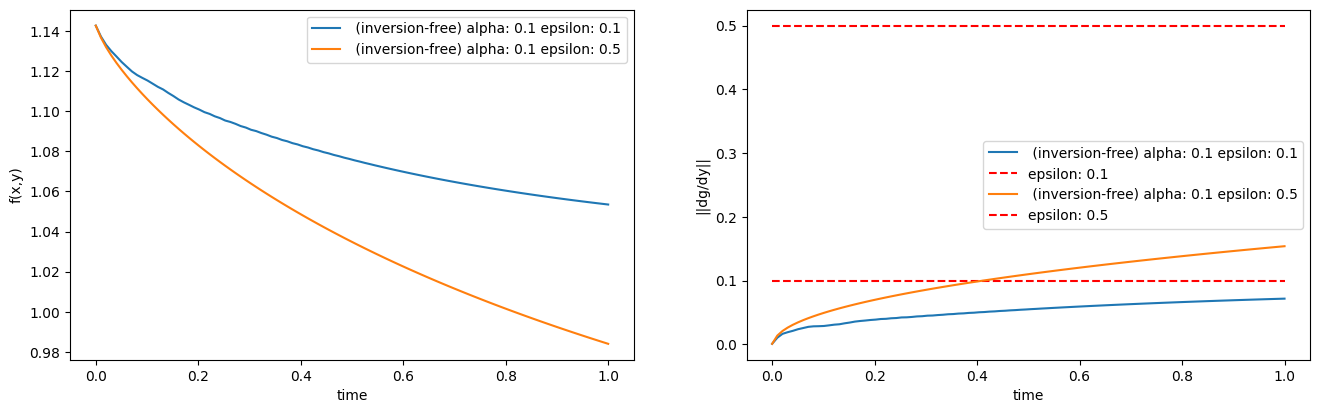

In [6]:
plt.figure(figsize=(16, 10))
# (False, None, None), 
# (inversionFree, eta, alpha)
for (inversionFree, eta, alpha) in [(True, 1, 0.1)]:
    for epsilon in [0.1, 0.5]:
        torch.manual_seed(0)
        x = torch.randn((dim, 1), requires_grad=True, dtype=torch.float32)
        y = solveLL(x)
        # 
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        print('LL error: ', torch.linalg.norm(dgdy, 2))
        # Time points where the solution is computed
        t = torch.linspace(0, 1, 100)

        # Solve the system of ODEs
        initial_conditions = torch.cat((x, y), 0)
        dxdt = torch.zeros((dim, 1))
        solution = torchdiffeq.odeint(system, initial_conditions, t, method='rk4')

        lossF, lossG, LLerror = [], [], []
        for i in range(len(solution)):
            lossF.append(f(solution[i, :dim], solution[i, dim:])[0].detach().numpy())
            __, __, __, dgdy, __, __ = calc_derivatives(solution[i, :dim], solution[i, dim:])
            lossG.append(torch.linalg.norm(dgdy).detach().numpy())

        plt.subplot(2, 2, (1 if inversionFree else 3))
        plt.plot(t, lossF, label= (' (inversion-free)' if inversionFree else ' Second-order') +\
                        (' alpha: ' + str(alpha) + ' epsilon: ' + str(epsilon)))
                        # (' Projection method 1' if projectionMethod == 1 else ' Projection method 2'))
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('f(x,y)')
        # -----------------------------------------------------
        plt.subplot(2, 2, 1 * (1 if inversionFree else 3) + 1)
        plt.plot(t, lossG, label=(' (inversion-free)' if inversionFree else ' Second-order') +\
                        (' alpha: ' + str(alpha) + ' epsilon: ' + str(epsilon)))
                        # (' Projection method 1' if projectionMethod == 1 else ' Projection method 2'))
        plt.plot(t, [epsilon] * len(t), 'r--', label='epsilon: ' + str(epsilon))
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('||dg/dy||')


plt.show()

In [7]:
lossG[:5], '--', lossG[-1]

([array(0.00099942, dtype=float32),
  array(0.01389381, dtype=float32),
  array(0.02111343, dtype=float32),
  array(0.0264158, dtype=float32),
  array(0.03081402, dtype=float32)],
 '--',
 array(0.1540697, dtype=float32))